# Learning to Play the Zoning Game: Supervised

Let's actually do some machine learning. Here, we will train a neural network to mimic a greedy policy and a greedy value function by supervised learning. We will play a bunch of random games and take the output of some greedy policy (either `polich_indiv_greedy` or `policy_total_greedy`), alongside the "current grid score," as training data for a neural network with a policy head and a value head.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from nsai_experiments.zoning_game.zg_gym import Tile
from nsai_experiments.zoning_game.zg_policy import create_policy_random, create_policy_indiv_greedy

from nsai_experiments.zoning_game.notebook_utils import get_zg_data

In [3]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(DEVICE)

cuda


## Part 1: no streaming, random policy, only train value
Here, we focus on a single-headed value network and we use a pre-determined policy to generate a bunch of data ahead of time.

In [4]:
shuffle_before_split = True
valid_frac = 0.15
test_frac = 0.15

torch.manual_seed(47)
# Not using moves data yet
states_tensor, values_tensor, _ = get_zg_data(create_policy_random, n_games = 100_000)

full_dataset = TensorDataset(states_tensor, values_tensor)
if shuffle_before_split:
    indices = torch.randperm(len(full_dataset))
    full_dataset = TensorDataset(states_tensor[indices], values_tensor[indices])

valid_size = int(valid_frac * len(full_dataset))
test_size = int(test_frac * len(full_dataset))
train_size = len(full_dataset) - valid_size - test_size

# Perform the split
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

print(f"Train size: {len(train_dataset)}, validation size: {len(valid_dataset)}, test size: {len(test_dataset)}")

Loading data from disk: zg_data/create_policy_random__100000
Train size: 1513124, validation size: 324240, test size: 324240


In [5]:
class StepOneValueNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()

        input_length = grid_size*grid_size*2
        one_hot_length = input_length * len(Tile)  # 432

        # n_hidden_1 = one_hot_length*2
        # n_hidden_2 = one_hot_length
        # n_hidden_3 = input_length
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden_1),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_1, n_hidden_2),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_2, n_hidden_3),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden_3, 1)
        # )

        # Best val loss: 2.4 after 50 epochs
        # n_hidden = 2592
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )

        # n_hidden = 2592
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )

        # n_hidden = 432
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(one_hot_length, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )

        # Best val loss 32: 2.7 after 50 epochs
        # Best val loss 54: 2.1 after 50 epochs
        # out_channels = 32
        # self.conv1 = nn.Conv2d(len(Tile), out_channels, kernel_size=3, stride=1, padding=1)
        # n_hidden = 432
        # self.linear_relu_stack = nn.Sequential(
        #     nn.ReLU(),
        #     nn.Linear(input_length*out_channels//2, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, 1)
        # )
        # x = x[:, :36]
        # x = x.reshape(-1, 6, 6)
        # x = F.one_hot(x, num_classes=len(Tile)).to(torch.float32)
        # x = self.conv1(x)
        # x = torch.flatten(x, start_dim=1)
        # x = self.linear_relu_stack(x)
        # return x

        out_channels = 54
        self.conv1 = nn.Conv2d(len(Tile), out_channels, kernel_size=3, stride=1, padding=1)
        n_hidden = 432
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(input_length*out_channels//2, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )


    def forward(self, x):
        x = x[:, :36]
        x = x.reshape(-1, 6, 6)
        x = F.one_hot(x, num_classes=len(Tile)).to(torch.float32)
        x = self.conv1(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear_relu_stack(x)
        return x

In [6]:
def train_step_one_value_network(model, train_dataset, valid_dataset, epochs=10, batch_size=1024, learning_rate=0.002, l1_lambda = 1e-4, weight_decay = 5e-2, device = DEVICE):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    torch.manual_seed(47)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    train_mini_losses = []
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        abs_differences = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                valid_loss += loss.item()
                abs_differences.extend(torch.abs(outputs.squeeze() - targets).cpu().numpy())

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(val_loader))

        # Calculate max, min, and mean absolute differences
        max_abs_diff = np.max(abs_differences)
        min_abs_diff = np.min(abs_differences)
        mean_abs_diff = np.mean(abs_differences)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, "
              f"Max Abs Diff: {max_abs_diff:.4f}, Min Abs Diff: {min_abs_diff:.4f}, Mean Abs Diff: {mean_abs_diff:.4f}")

    return model, train_mini_losses, train_losses, valid_losses

def plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = False):
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.scatter(np.linspace(0, len(train_losses)-1, len(train_mini_losses)), train_mini_losses, label='Train Mini Loss', s=5, color='gray')
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    if log_scale: plt.yscale('log')
    plt.xlim([0, len(train_losses)-1])
    plt.legend()
    plt.grid(True)
    plt.show()

100%|██████████| 1478/1478 [00:10<00:00, 139.52it/s]


Epoch 1/5, Train Loss: 25.2983, Val Loss: 7.0345, Max Abs Diff: 27.6709, Min Abs Diff: 0.0000, Mean Abs Diff: 2.0691


100%|██████████| 1478/1478 [00:10<00:00, 141.16it/s]


Epoch 2/5, Train Loss: 6.5685, Val Loss: 5.0873, Max Abs Diff: 19.9078, Min Abs Diff: 0.0000, Mean Abs Diff: 1.7800


100%|██████████| 1478/1478 [00:10<00:00, 147.22it/s]


Epoch 3/5, Train Loss: 4.9789, Val Loss: 4.5019, Max Abs Diff: 21.1338, Min Abs Diff: 0.0000, Mean Abs Diff: 1.6629


100%|██████████| 1478/1478 [00:10<00:00, 146.35it/s]


Epoch 4/5, Train Loss: 4.3047, Val Loss: 2.7029, Max Abs Diff: 18.9099, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2821


100%|██████████| 1478/1478 [00:10<00:00, 146.35it/s]


Epoch 5/5, Train Loss: 3.6504, Val Loss: 2.7053, Max Abs Diff: 19.0911, Min Abs Diff: 0.0000, Mean Abs Diff: 1.2847


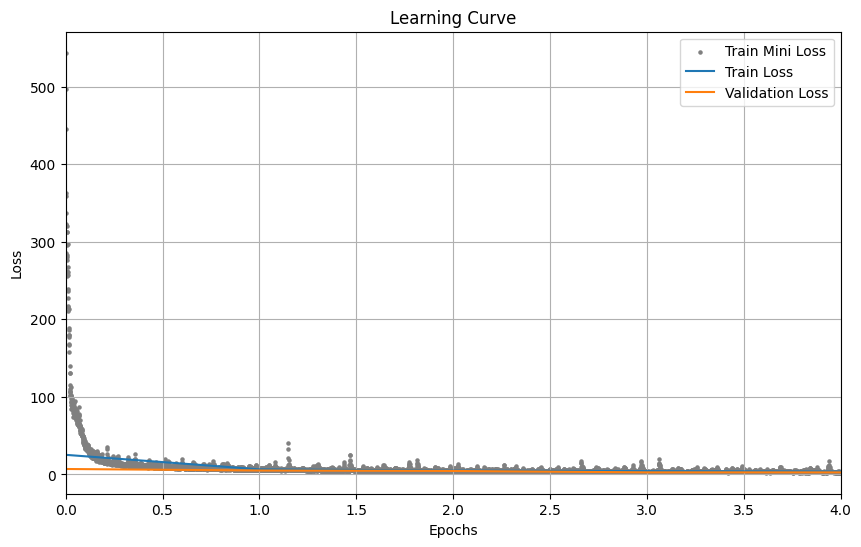

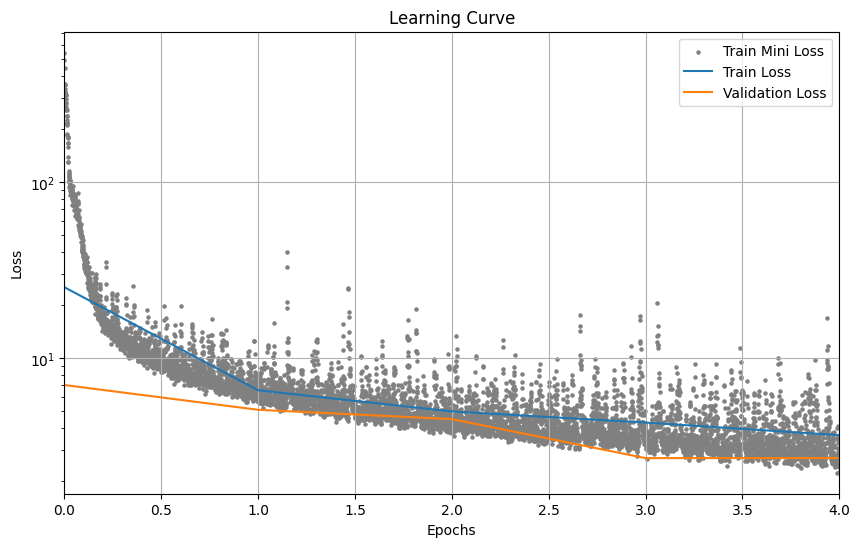

In [7]:
model = StepOneValueNetwork()
model, train_mini_losses, train_losses, valid_losses = train_step_one_value_network(model, train_dataset, valid_dataset, epochs = 5)

plot_learning_curve(train_mini_losses, train_losses, valid_losses)
plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = True)

## Part 2: No streaming, individual greedy policy, only train policy 

Success. Now, same thing but we want to learn the policy, not the value. We'll try to learn the `indiv_greedy` policy.

In [8]:
states_tensor, _, moves_tensor = get_zg_data(create_policy_indiv_greedy, n_games = 100_000)

print(states_tensor.shape)
print(moves_tensor.shape)

Loading data from disk: zg_data/create_policy_indiv_greedy__100000
torch.Size([2161604, 72])
torch.Size([2161604])


In [9]:
torch.manual_seed(47)
full_dataset_2 = TensorDataset(states_tensor, moves_tensor)
if shuffle_before_split:
    indices = torch.randperm(len(full_dataset_2))
    full_dataset_2 = TensorDataset(states_tensor[indices], moves_tensor[indices])

valid_size_2 = int(valid_frac * len(full_dataset_2))
test_size_2 = int(test_frac * len(full_dataset_2))
train_size_2 = len(full_dataset_2) - valid_size_2 - test_size_2

# Perform the split
train_dataset_2, valid_dataset_2, test_dataset_2 = random_split(full_dataset_2, [train_size_2, valid_size_2, test_size_2])

print(f"Train size: {len(train_dataset_2)}, validation size: {len(valid_dataset_2)}, test size: {len(test_dataset_2)}")

Train size: 1513124, validation size: 324240, test size: 324240


In [10]:
class StepTwoPolicyNetwork(nn.Module):
    def __init__(self, grid_size = 6):
        super().__init__()
        self.grid_size = grid_size
        self.grid_length = grid_size*grid_size
        self.input_length = self.grid_length*2
        self.num_classes = len(Tile)

        kernel_size = 3
        out_channels = self.num_classes*kernel_size*kernel_size
        n_into_linear = self.grid_length*out_channels + self.grid_length*self.num_classes
        n_hidden = self.input_length*self.num_classes
        
        self.conv1 = nn.Conv2d(self.num_classes, out_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.linear_relu_stack = nn.Sequential(
            nn.ReLU(),
            nn.Linear(n_into_linear, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(n_hidden, self.grid_length)
        self.value_head = nn.Linear(n_hidden, 1)


    def forward(self, x):
        assert x.shape[1] == self.input_length
        x = F.one_hot(x, num_classes=self.num_classes).to(torch.float32)

        x_grid = x[:, :self.grid_length, :].reshape(-1, self.grid_size, self.grid_size, self.num_classes)
        x_grid = self.conv1(x_grid)
        x_grid = torch.flatten(x_grid, start_dim=1)

        x_queue = x[:, self.grid_length:]
        x_queue = torch.flatten(x_queue, start_dim=1)

        x = torch.cat((x_grid, x_queue), dim=1)
        x = self.linear_relu_stack(x)
        x = self.policy_head(x)
        return x

In [11]:
def train_step_two_policy_network(model, train_dataset, valid_dataset, epochs=10, batch_size=1024, learning_rate=0.001, l1_lambda = 0, weight_decay = 5e-3, device = DEVICE):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    train_mini_losses = []
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            loss = loss.item()
            train_mini_losses.append(loss)
            train_loss += loss

        # Validation phase
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                valid_loss += loss.item()

        # Record losses
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(val_loader))

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, ")

    return model, train_mini_losses, train_losses, valid_losses

100%|██████████| 1478/1478 [00:10<00:00, 140.77it/s]


Epoch 1/5, Train Loss: 2.7179, Val Loss: 2.4655, 


100%|██████████| 1478/1478 [00:10<00:00, 139.89it/s]


Epoch 2/5, Train Loss: 2.3764, Val Loss: 2.2874, 


100%|██████████| 1478/1478 [00:10<00:00, 141.35it/s]


Epoch 3/5, Train Loss: 2.2310, Val Loss: 2.1653, 


100%|██████████| 1478/1478 [00:10<00:00, 141.95it/s]


Epoch 4/5, Train Loss: 2.1215, Val Loss: 2.1004, 


100%|██████████| 1478/1478 [00:10<00:00, 139.01it/s]


Epoch 5/5, Train Loss: 2.0775, Val Loss: 2.0488, 


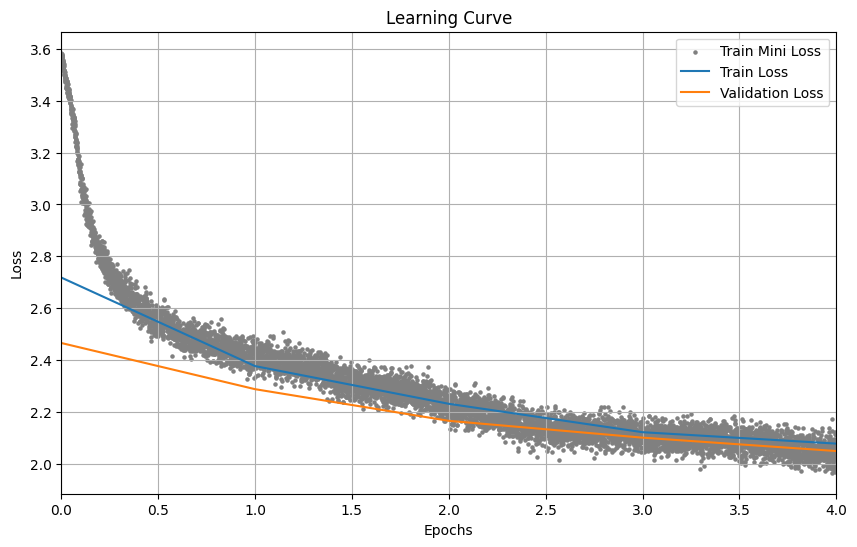

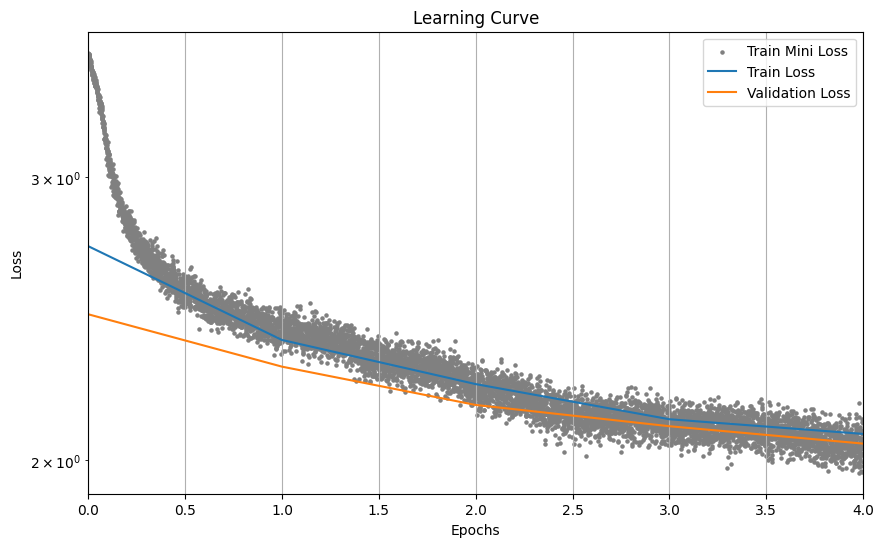

In [12]:
model = StepTwoPolicyNetwork()
model, train_mini_losses, train_losses, valid_losses = train_step_two_policy_network(model, train_dataset_2, valid_dataset_2, epochs = 5)

plot_learning_curve(train_mini_losses, train_losses, valid_losses)
plot_learning_curve(train_mini_losses, train_losses, valid_losses, log_scale = True)